<font size=6>**DL CNNs**</font> </h6>

<div style="border: 1px solid lightgray; padding: 10px; background-color: #f9f9f9;">

<font size=1>

    Summer School for AstroStatistics in Sharjah 2025

The content presented in this notebook is the original work of the authors, unless specified otherwise.
Any publicly available material incorporated is properly credited to its respective sources.
All references to published papers, datasets, and software tools are duly acknowledged.
The original content of this notebook is licensed under the GNU General Public License v3.0 (GNU GPLv3).
</font>
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">


In this session we dive into one of the most commonly used applications of DL which corresponds to the **Convolutional Neural Networks**. We will use mock images to classify galaxies, QSOs, and stars. <br>
The goals are:

- to get a grasp of what **CNNs are** 
- to **build and train** a DL network

In the example that will follow we are mainly going through these steps:

    1. Load (mock) Data
    2. Define Model
    3. Compile Model
    4. Fit Model 
    5. Iterate steps 2-3-4 (by adjusting various parameters or the model architecture)
    6. Evaluate Model
    8. Predict class

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Set up a fancy plot style (you can comment it out without consequences)
import sys; sys.path.append('../src'); import plot_style

import warnings
warnings.filterwarnings(action='ignore')


import scipy.io as scio
import keras
from IPython.display import clear_output
import keras.utils as ult
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization,Conv3D, MaxPooling3D, Dense, Add, Activation
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time

2025-06-20 03:15:48.614952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750378548.716613  601699 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750378548.743659  601699 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750378548.942512  601699 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750378548.942540  601699 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750378548.942544  601699 computation_placer.cc:177] computation placer alr

# A small introduction

## What are Convolutional Neural Networks (CNN)

> Is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. <br>
>
> _[A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way, by Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)_

## Example of CNN architecture

![CNN_schematic](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

The design of CNN allows to apply similar concepts to Neural Networks with special data processing techniques on data and between layers to learn from image data. 

## Components

### Convolutional Layers

The convolution in CNNs is a technique inspired by the organization of the visual cortex, as neurons respond to stimulius in a given field of view. The convolution is a way to propogate information from nearby pixels in an image. 

>The aim of CNN is to **reduce the dimensions** and **keep the most important features** that help in good predictions.  

Essentially a convolution is a matrix multiplication between the image and a *kernel* (another matrix, smaller than the image). Note, the shape of your input data has changed after going through the convolution (_'valid padding'_, in contrast to _'same padding'_ where the original dimensions are kept)

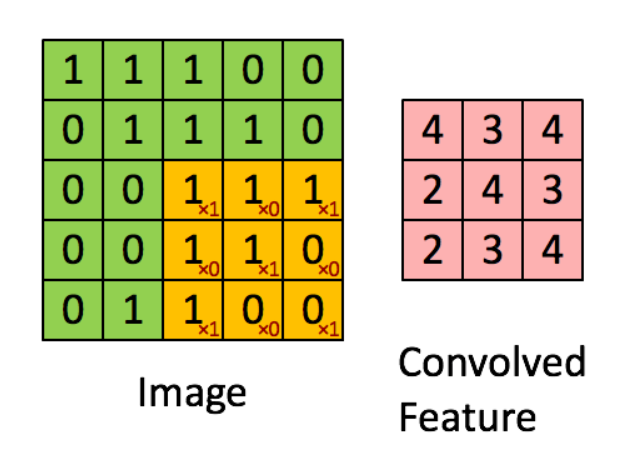

![convolution](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)
<div style="text-align: center;">
Convoluting a 5x5x1 image with a 3x3x1 kernel to get a 3x3x1 convolved feature. The kernel (shown in yellow) takes into account only the pixels in the two diagonals (marked as 'x1' in the lower right corner of the yellow matrix). Therefore, in the first (frozen) image there are 9 pixels with the kernel considering 5 of them with values : 1+1+0+1+1 = 4 (the value transfered to the convoled feature).
</div>

The kernel is not necessary to move one pixel at a time. By changing the _stride_ we can select any kind of movement, which includes both the width and the height. A (1,1) stride will move one pixel right (stating always from the top left corner) and after completing the row it will move one pixel down (and left again). A (2,2) will do the similar thing but with two pixels moves. However, in this case we also **downsampling** the extracted feature. 

### Activation function

The function used to impose a non-linear transformation to the input data. Perhaps the most typical one used is the ReLU (Rectified Linear Unit), which has the advantage of not activating all neurons at the same time.  

### Pooling

Sometimes data is big and we want to speed up the process. Can we *pool* some cells together to reduce our data size between convolutions? Yes! The technique is called (obviously...) _pooling_ and it can be performed by either taking the average of all the pixels that the pooling layer is over the feature layer (**average pooling**) or the maximum value found in any of the pixels (**max pooling**). 

![pooling_2](https://miro.medium.com/max/1192/1*KQIEqhxzICU7thjaQBfPBQ.png)
<div style="text-align: center;">
Examples of max and average pooling. 
</div>

![pooling_1](https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif)
<div style="text-align: center;">
A 3x3 max pooling acting over a 5x5 feature map. 
</div>

The benefits of pooling layers are: i. the **decrease of dimensions** that help the decrease the computational power, ii. they extract the most **dominant features which are rotational and positional invariant**. 

There are two flavors of pooling layers, either local (with dimensions smaller that the feature dimensions) or _global_ that act on the whole feature layer (and they actually convert it to a single value), which is more aggressive. 

### Fully connected layer

This is the fundamental layer where each neuron in the layer is connected to every neuron in the previous layer. This type of layer is also known as a dense layer because each neuron is connected to all neurons in the preceding layer.
 

### Dropout

One way to prevent overfitting is the dropout method - remove individual nodes from the network (with some probability) at each training stage. This could be at the level of the input node or at hidden layers.

### Batch Normalization

Each layer's weights (and therefore outputs) are updated every training iteration. More layers can mean larger changes down the network (nonlinear behavior), for small changes in weights, so small learning rates may be needed which makes training hard. Instead we may enforce each layer to produce **predictable** output from layer to layer using batch normalization giving more stable behavior and reducing training time. Predictable in this case means that the distribution of outputs from the previous layer has specific properties: unit variance, zero mean. In other words it is a technique to standardize the input to a layer. ([Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167))

(Source: images and material mostly from [this web article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

## Example classification networks

AlexNet & LeNet: image classification networks - "In ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2010, AlexNet was trained to classify 1.2 million high-resolution images into 1000 different classes. It achieved top-1 and top-5 error rates of 37.5% and 17%, which outperforms state-of-the-art methods at that time." [article](https://medium.com/mlearning-ai/alexnet-and-image-classification-8cd8511548b4)
    
![example network architectures](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

## Visualization of layers

There follow a few links that help to visualize how CNN works: 

- [CNN explainer](https://poloclub.github.io/cnn-explainer/)

- [CNN demo on MNIST dataset](https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html)

# Galaxy morphology estimation

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
<font size=4>**Exercise 1:**</font>    

**Objective:** Build a CNN model to classify stars, spiral and elliplical galaxies.

**Task:** Using synthetic data (images with noise), follow these steps:
    
- load data
       
- split data (train/validation/test)
    
- build model 
    
- train the model
    
- evaluate its performance
    
- check some intermediate steps.

</div>


Helpful functions

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.losses2.append(logs.get('categorical_accuracy'))
        self.val_losses2.append(logs.get('val_categorical_accuracy'))

        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses2, label="Training accuracy",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Validation accuracy",linestyle='--')
        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, label="Training loss",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Validation loss",linestyle='--')

        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
def show_images(images,galaxy_labels):
    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[0]))
    plt.imshow(images[0,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[0,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[0,:,:,2], vmax=255)
    plt.axis('off')

    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[1]))
    plt.imshow(images[1,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[1,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[1,:,:,2], vmax=255)
    plt.axis('off')

    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[5]))
    plt.imshow(images[5,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[5,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[5,:,:,2], vmax=255)
    plt.axis('off')

In [4]:
def label_trans(label_id):
    if label_id==0: return "star"
    if label_id==1: return "spiral galaxy"
    if label_id==2: return "elliptical galaxy"
    else: return "unknown"  

## Load the data

**data**: are images at different wavelenghts i.e. 3D with 2 spatial (41x41 pixels) and 1 spectral (3 bands) dimension     
**labels**: take values 0: star, 1: spiral galaxy, 2: elliptical galaxy   

[(10000, 41, 41, 3), (10000,)]


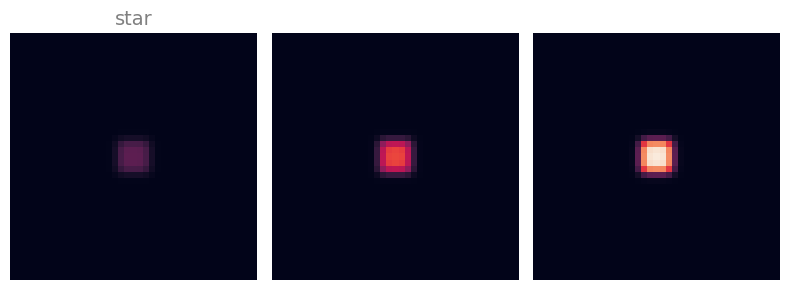

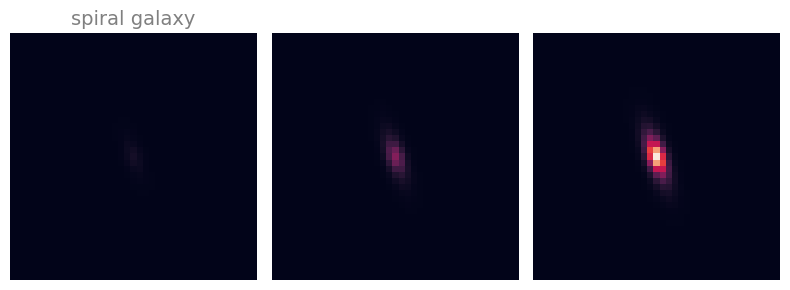

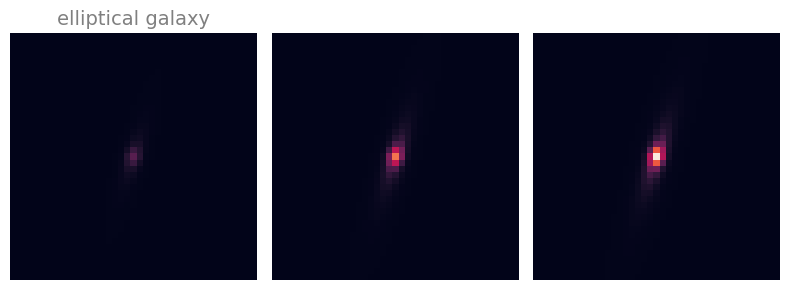

In [5]:
with np.load('data/galaxy_cubes.npz') as data:
    images = data['images']
    galaxy_labels = data['labels']

print([images.shape, galaxy_labels.shape])

show_images(images,galaxy_labels) 

## Add white noise to observations

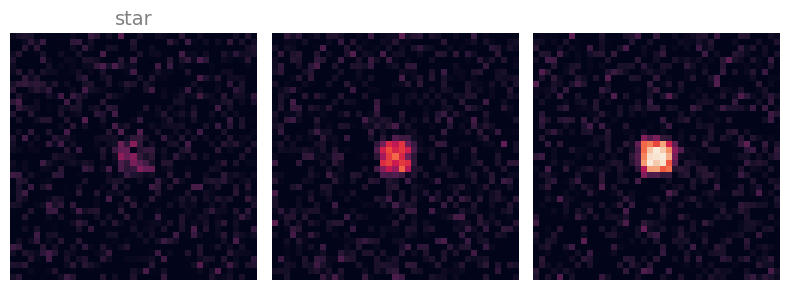

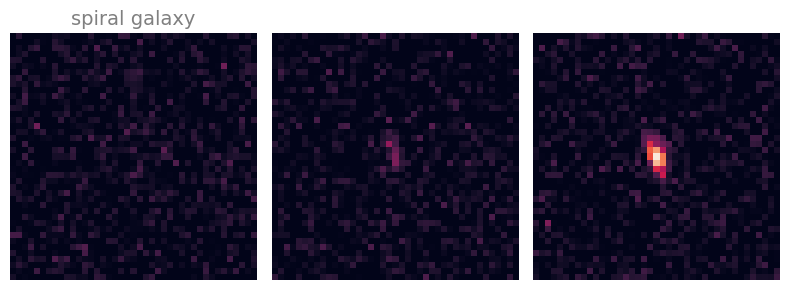

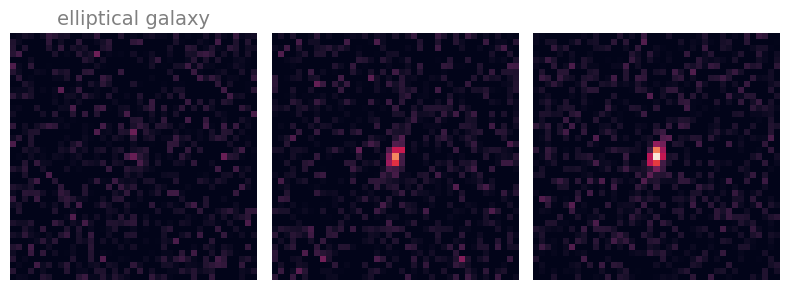

In [6]:
images= images+np.random.randn(10000,41,41,3)*20
images= np.clip(images, 0, 255)

show_images(images,galaxy_labels) 

## Create training and testing (validation) dataset

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Split the sample into train/validation/test
    
</div>


_HINT:_ to test various architectures fast keep the train/test sizes rather **small**, i.e. use a huge fraction for test to get a very small number for train+validation (a few hundrends). At the end you would like to retrain with the **full dataset** (that will take some time).

In [7]:
# using two times the train_test_split to get initially 
# the test sample and then train and validation.
# 
# you can use random_state if you want to reproduce the same exact splits
# and shuffle if you want to mix the data before splits

X_train_full, X_test_img, y_train_full_lbl, y_test_lbl = train_test_split(
        images , galaxy_labels, test_size=0.95) #, shuffle = True, random_state=42)

# split into train and validation
X_train_img, X_valid_img, y_train_lbl, y_valid_lbl = train_test_split(
        X_train_full , y_train_full_lbl , test_size=0.3) #, shuffle = True, random_state=24 )

print(f'From {len(images)} images, we use as:')
print(f'test: \t\t {len(X_test_img)}')
print(f'train: \t\t  {len(X_train_img)}')
print(f'validation:\t  {len(X_valid_img)}')

# NOTE: this is a data manipulation as keras needs the number of objects 
# with properties at each "channel", and their correspoding number. 
# As keras thinks of images as RGB it uses 3 as last number. 
# To avoid keras to assume anything add specifically ',1' at the end.

X_train = X_train_img.reshape(len(X_train_img), images.shape[1],images.shape[2],images.shape[3],1)
X_valid = X_valid_img.reshape(len(X_valid_img), images.shape[1],images.shape[2],images.shape[3],1)
X_test  = X_test_img.reshape(len(X_test_img), images.shape[1],images.shape[2],images.shape[3],1)


# NOTE: converting labels to categorical representation, 
# a vector whose position indicates its class
# 0: star, ---------------> [1, 0, 0] 
# 1: spiral galaxy, ------> [0, 1, 0]
# 2: elliptical galaxy ---> [0, 0, 1]   
y_train = ult.to_categorical(y_train_lbl,num_classes=3)
y_valid = ult.to_categorical(y_valid_lbl,num_classes=3)
y_test  = ult.to_categorical(y_test_lbl,num_classes=3)
      

From 10000 images, we use as:
test: 		 9500
train: 		  350
validation:	  150


## Define network layers and characteristics

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Build the CNN model. 
    
- For this you need to apply a set of different CNN layers along with others such as pooling, dropout, etc. 
    
- Feel free to play around with the number and types of layers. Also adjust the number of nodes per layer, kernel size and strides.
    
- How many nodes the last layer should have?
    
- Take extra care to use the right layer as input at each layer (functional form).    
</div>


In [8]:
inputs = Input((images.shape[1], images.shape[2], images.shape[3], 1),name='main_input')

conv00  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv00')(inputs)
act00 = Activation('relu')(conv00)
pool00  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act00)


conv10  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv10')(pool00)
act10 = Activation('relu')(conv10)
pool10  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act10)

conv20  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv20')(pool10)
act20 = Activation('relu')(conv20)
pool20  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act20)

# do not remove!
fl0 = Flatten(name='fl0')(pool20)
fc0 = Dense(32,activation='linear')(fl0)
fc1 = Dense(8,activation='linear')(fc0)

# do not remove!
Dn0 = Dense(3,activation='softmax', name='Dn0' )(fc0)

my_model = Model(inputs=[inputs], outputs=[Dn0])



2025-06-20 03:18:09.002966: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Selecting Adam optimizer to compile the model.

_HINT:_ check the documentation ([keras:accuracy_metrics](https://keras.io/api/metrics/accuracy_metrics/)) and remember that we are using the categorical labels. 

In [10]:
my_model.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(learning_rate=1e-4), 
                 metrics =['categorical_accuracy'])
my_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 41, 41, 3, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv00 (Conv3D)                 │ (None, 41, 41, 3, 16)  │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 41, 41, 3, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 21, 21, 3, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv10 (Conv3D)                 │ (None, 21, 21, 3, 16)  │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 21, 21, 3, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 11, 11, 3, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv20 (Conv3D)                 │ (None, 11, 11, 3, 16)  │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 11, 3, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 6, 6, 3, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fl0 (Flatten)                   │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dn0 (Dense)                     │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,979 (253.82 KB)

 Trainable params: 64,979 (253.82 KB)

 Non-trainable params: 0 (0.00 B)

## Train the network

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Fill the missing code to train the model
    
</div>

_HINT:_ You may increase the **batch_size**, and decrease the number of **epochs**, when testing in order to minimize the training time.


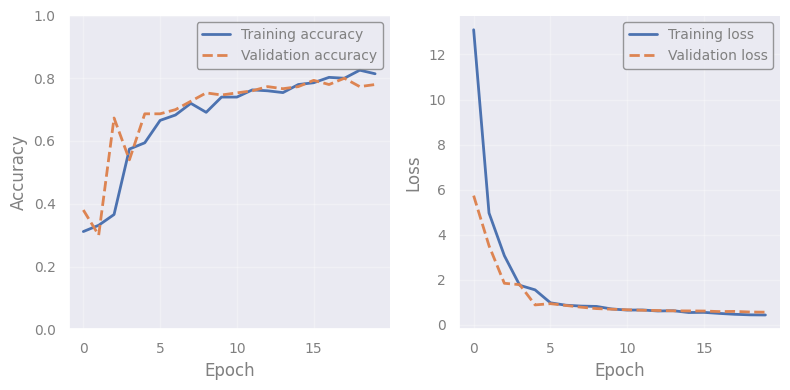

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 851ms/step - categorical_accuracy: 0.7913 - loss: 0.4896 - val_categorical_accuracy: 0.7800 - val_loss: 0.5671


'00:01:44'

In [11]:
start_time = time.time() 
                                                    
history=my_model.fit( X_train , y_train , 
                    batch_size= 64, 
                    epochs= 20,
                    validation_data=[ X_valid , y_valid ],
                    callbacks=[plot_losses],shuffle=True)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

## Check performance

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** evaluate the model (take care on which dataset!) 
    
</div>

_HINT_: if you want to speed up the process a bit select the number of TO objects of the test set (eg first 100).

In [12]:
TO = len(X_test) # or smaller...

ls,acc=my_model.evaluate( X_test[0:TO], y_test[0:TO])  
print("Loss value: %.2f" % (ls))  
print("Accuracy: %.1f" % (acc*100))   

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - categorical_accuracy: 0.7317 - loss: 0.6906
Loss value: 0.69
Accuracy: 72.9


## Predict label for particular example

In [13]:
# select object
obj = 33        # must be less than len( X_test)

preds = my_model.predict( X_test[obj:obj+1,:,:,:,:])
print(f"Probability per class: {', '.join([str(i*100)[0:5]+'%' for i in preds[0]])}")
print(f'Highest for class: {label_trans( np.argmax(preds))}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Probability per class: 1.775%, 0.030%, 99.96%
Highest for class: elliptical galaxy


## Print the activations for particular inputs

Using `model.layers` we print all layers of the model.

In [14]:
my_model.layers

[<InputLayer name=main_input, built=True>,
 <Conv3D name=conv00, built=True>,
 <Activation name=activation, built=True>,
 <MaxPooling3D name=max_pooling3d, built=True>,
 <Conv3D name=conv10, built=True>,
 <Activation name=activation_1, built=True>,
 <MaxPooling3D name=max_pooling3d_1, built=True>,
 <Conv3D name=conv20, built=True>,
 <Activation name=activation_2, built=True>,
 <MaxPooling3D name=max_pooling3d_2, built=True>,
 <Flatten name=fl0, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=Dn0, built=True>]

We can select for which one to print the activations.

_HINT: select convolutional layers to check them.

In [15]:
sel_layer = 1  # eg 1

my_model.layers[sel_layer]

<Conv3D name=conv00, built=True>

Selecting a random sample to present.

_HINT: to avoid issues with plots check that the number of nodes in the concolution layer is properly trasnfered to the plotting for-loop of activation layers_

Compare this with what we see with the [CNN explainer](https://poloclub.github.io/cnn-explainer/).

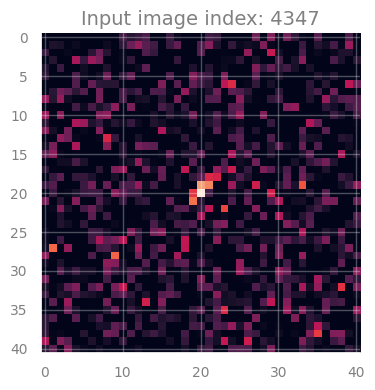

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


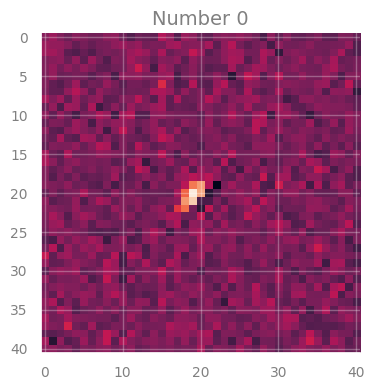

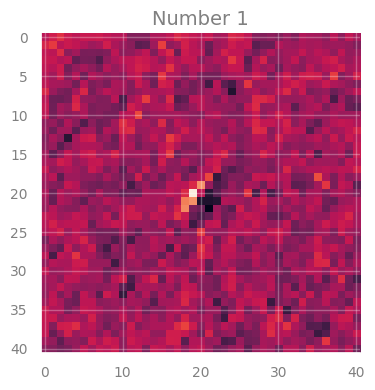

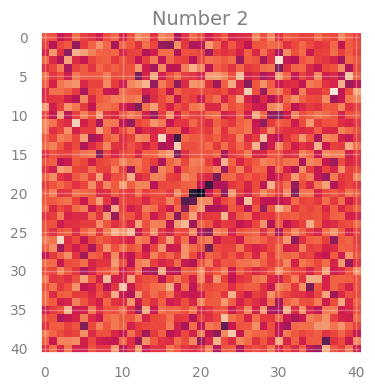

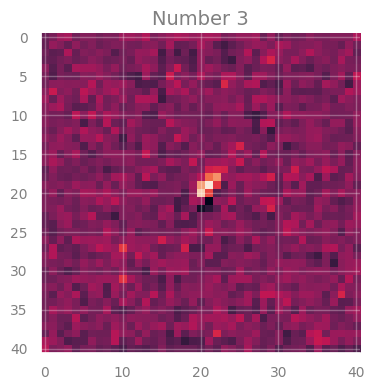

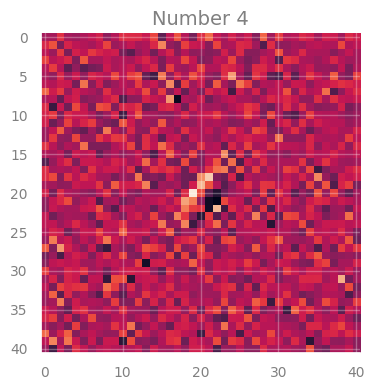

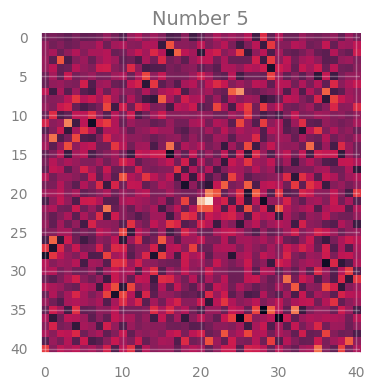

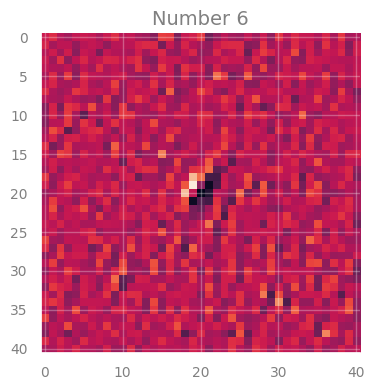

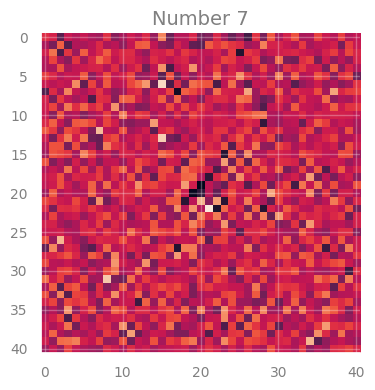

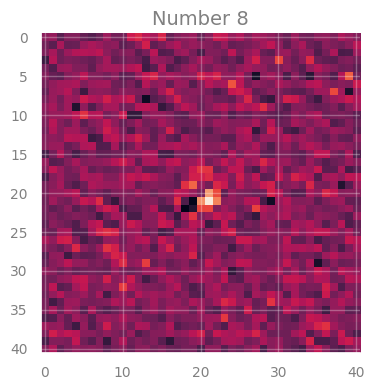

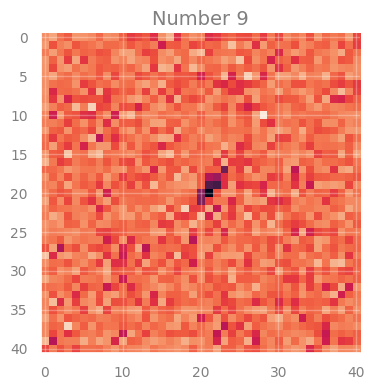

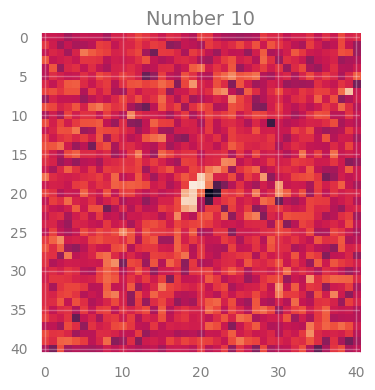

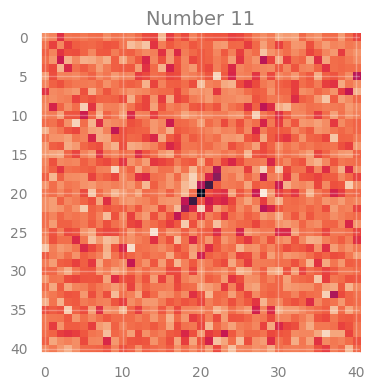

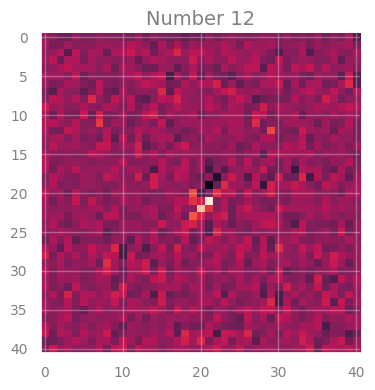

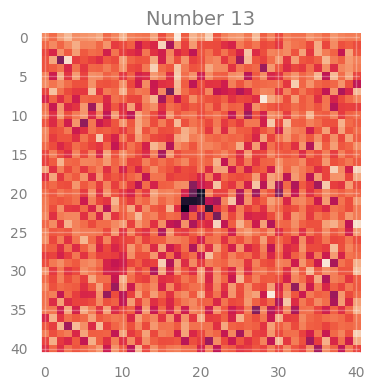

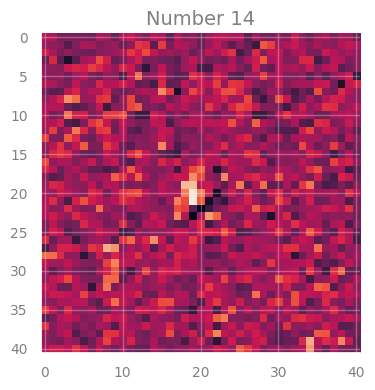

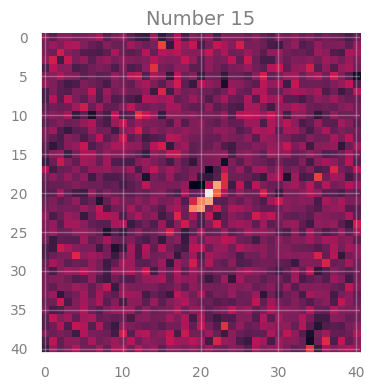

In [16]:
s = np.random.randint(0,len(X_test)-1)

plt.imshow(X_test[s,:,:,0,0])
plt.title(f'Input image index: {s}')
plt.show()

# using the specific layer as an output
lr = my_model.layers[sel_layer].output  
activation_model_lr = Model(inputs=[inputs], outputs=lr)

# extracting the activations of specific layer (as a model)
activations_lr = activation_model_lr.predict( X_test[s:s+1,:,:,:,:]) 

# NOTE: check the number of nodes in the CNN
for i in np.arange(16):
    img=activations_lr[0,:,:,0,i]
    plt.imshow(img)
    plt.title('Number ' + str(i))
    plt.show()
plt.show()

In [ ]:
# EOF